<a href="https://colab.research.google.com/github/ethompson93/dmri_analysis_techniques/blob/main/ball_and_stick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Compartment models: ball and stick**

In this coding assignment, you will be fitting a simple compartment model to your data: the ball and stick model.

Using the same sample data as the previous exercise, download from https://drive.google.com/drive/folders/1hpbkkm4JuLoV3EGiQrGDAHjmypW0m7UP?usp=drive_link  and upload it to this Google collab.

# The data

This coding exercise uses... summary of phantom data with some images of slices... lets update this when we've settled on a dataset

## Loading Variables

We'll re-use the code from the previous exercise to load in the data and extract the relevant variables.

In [ ]:
## Import libaries
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


In [ ]:
## Nifti Images

# Load our nifti image as "dwi_img" and get data to "dwi"
dwi_img = nb.load('fibrecup.nii.gz')
dwi = dwi_img.get_fdata()

# repeat this with the white matter mask
mask_img = nb.load('wm_mask.nii.gz')
mask = mask_img.get_fdata()

## Gradient information
# Load our gradient text file at grad
grad = np.loadtxt('grad.txt')

# select our gradient direction as "g"
g = grad[:,0:3]

# select our b-values as "b"
b = grad[:,3]

## Reshaping
# find the index of the voxels within the white matter mask
idx = np.where(mask>0)
print(np.shape(idx))

# extract dwi values at these WM voxels to produce a matrix of
# [WM voxels x grad-dirs]. Save this as "dwi_wm"
dwi_wm = dwi[idx[0],idx[1],idx[2]]

## Extracting b0 & non-b0 diffusion signals
# find from gradients where the b-value is equal to zero as "b0idx"
b0idx = np.where(b==0)[0]

# find from gradients where the b-value is NOT equal to zero as "non_b0idx"
non_b0idx = np.where(b!=0)[0]

# Extract baseline signal ("S0") by indexing "dwi" at b0idx
S0 = dwi_wm[:,b0idx]

# Extract gradient weighted signal ("S") by indexing the "dwi" at non-b0 values
S = dwi_wm[:,non_b0idx]

(3, 2051)


# visualise the data


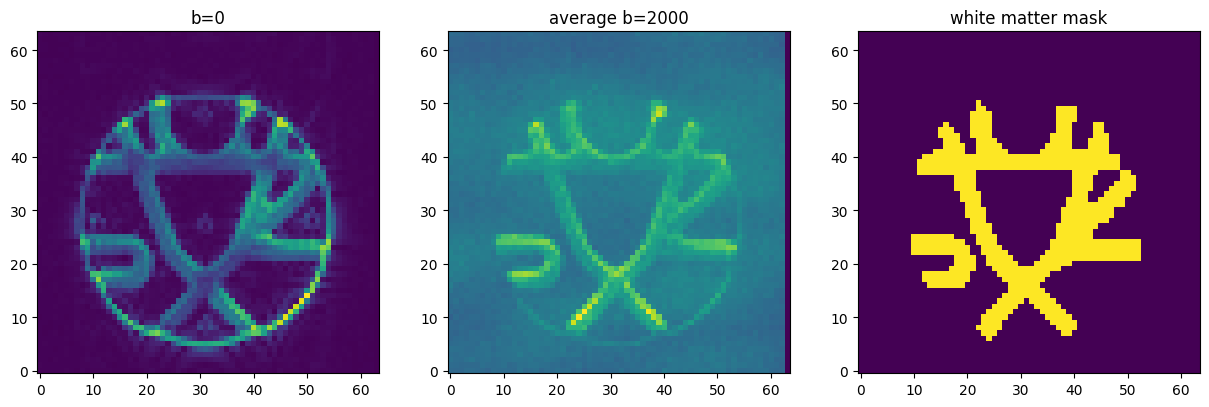

In [ ]:
# make a figure with three subplots for b=0, b=2000 and the wm mask
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(dwi[:,:,1,0].T, origin="lower")
axs[0].set_title("b=0")
axs[1].imshow(np.mean(dwi[:,:,1,1:], axis=2).T, origin="lower")
axs[1].set_title("average b=2000")
axs[2].imshow(mask[:,:,1].T, origin="lower")
axs[2].set_title("white matter mask")
plt.show()

## Coding Task – Fitting the ball and stick model to the data




**Task:** create function "ball_and_stick" to generate the expected diffusion signal from the ball and stick model.

Use the following parameters as inputs:

*   angles describing the orientation of the stick: `theta` and `phi`
  (check out the [wikipedia page](https://en.wikipedia.org/wiki/Spherical_coordinate_system) on spherical coordinates for a refresher on how these relate to the x-y-z coordinates)
*   volume fraction of the stick component: `f`
*   diffusivity constant: `d`
*   baseline signal when b = 0: `S0`
*   b-value of diffusion gradient: `b`
*   unit vector describing diffusion encoding gradient: `g`

[link to slides for the equations]




In [ ]:
def ball(b, d):
  pass

def stick(b, g, d, theta, phi):
  pass

def ball_and_stick(theta, phi, f, d, S0, b, g):
  pass

In [ ]:
#@title ANSWERS

def ball(b, d):
  return np.exp(-b*d)

def stick(b, g, d, theta, phi):
  v = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
  # Iterate through gradient directions in g
  result = np.zeros_like(b, dtype=float)  # Initialize result array
  for i in range(g.shape[0]):
    result[i] = np.exp(-b[i] * d * (np.dot(v, g[i, :])**2))
  return result

def ball_and_stick(theta, phi, f, d, S0, b, g):
  isotropic_signal = ball(b,d)
  anisotropic_signal = stick(b, g, d, theta, phi)
  return S0*((1-f)*isotropic_signal + f*anisotropic_signal)


Now we want to fit the model to our data. We have the values for `b`, `g`, `S0` from the data, and we can estimate `d` from the literature. [TODO: add a bit more info about where d comes from] We need to refine the parameters `theta`, `phi` and `f` to fit our model to the data.

Task: create a function that calculates the sum-of-squared error between the measured signal `S` and the simulated signal from the `ball_and_stick` function.

We will use this as our objective function in the next step.



In [ ]:
def sum_squared_error(x, S0, d, b, g, S):
  # x = [theta, phi, f]
  # the model parameters need to combined into variable x for the scipy least_squares function
  pass

In [ ]:
#@title ANSWER
def sum_squared_error(x, S0, d, b, g, S):
  # x = (theta, phi, f)
  SSE = np.sum((ball_and_stick(x[0], x[1], x[2], d, S0, b, g) - S)**2)
  return SSE

Now we can use non-linear least squares to fit the model. We have provided the code for this below.

Take a look at the documentation to help you understand the inputs to the least_squares function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html.

In [ ]:
d = 1.7e-3 # diffusion constant, found empirically
Nvox = np.shape(S0)[0]

# set up empty arrays to store the parameter estimates for each voxel
theta_estimates = np.zeros(Nvox)
phi_estimates = np.zeros(Nvox)
f_estimates = np.zeros(Nvox)

for i in range(Nvox):
  res = least_squares(sum_squared_error,
              x0 = [np.pi/2, np.pi, 0.5], # initial guesses for theta, phi, f
              args=(S0[i,:], d, b[non_b0idx], g[non_b0idx,:], S[i,:]), # additional arguments to pass to the sum_squared_error function
              bounds =([0,0,0], [np.pi, 2*np.pi, 1]), # lower and upper bounds for theta, phi, f
              ftol = 1e-9, xtol=1e-9) # tolerance values for termination

  # We record voxel-wise estimates for theta, phi and f
  theta, phi, f = res.x
  theta_estimates[i] = theta
  phi_estimates[i] = phi
  f_estimates[i] = f

This can take a few minutes.

In the meantime, think about ...
 * other methods that could be used to fit the model?
 * options in the least squares function to improve accuracy?
 * pros and cons of the ball and stick model?

[TODO]: add a bit assessing the model fit, so extension tasks can be evaluated. Also to compare with previous task

## Visualisation
Once the least-squares fit has finished running, we can visualise our results.

First, we can look at the directions of the "stick" component. We convert the `theta` and `phi` estimates into regular Cartesian coordinates.



In [ ]:
# get the vectors in cartesian coordinates (x,y,z) for visualisation
dirs = np.array([np.sin(theta_estimates)*np.cos(phi_estimates),
                 np.sin(theta_estimates)*np.sin(phi_estimates),
                 np.cos(theta_estimates)])

dirs = dirs.T

We visualise the sticks in the same was as we did with the principal directions from DTI.

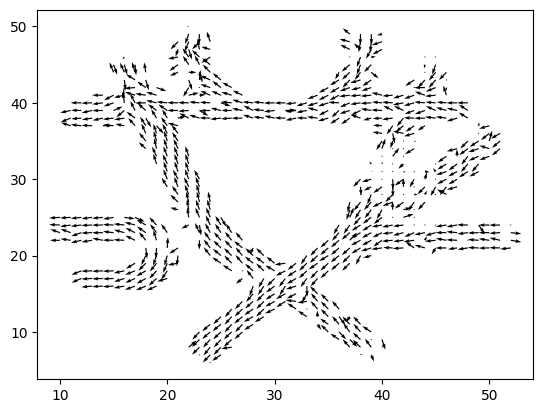

In [ ]:
# Choose a slice in which you will visualise the principal direction
slice_idx = np.where(idx[2]==1)

# Considering only the x and y components, plot a quiver plot of the prinicpal
# direction in each white matter voxel in this slice
# see matplotlib.pyplot.quiver documentation:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html

# x and y correspond to location of each arrow,
# i.e. the coordinates of the white matter voxel
x = idx[0][slice_idx]
y = idx[1][slice_idx]

# u and v correspond to the x and y components of the principal direction in
# each voxel
u = dirs[slice_idx,0]
v = dirs[slice_idx,1]

fig = plt.figure
plt.quiver(x,y,u,v, scale_units='x', scale=1)

plt.show()

Compare this output to the one from the previous exercise. Can you see any differences?

Next, we can plot the volume fractions of the stick components, `f`.

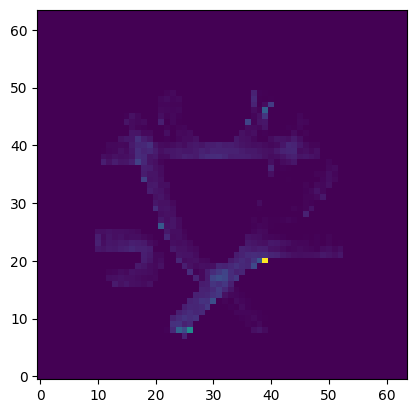

In [ ]:
# plot the fiber volume fractions
f_map = np.zeros_like(mask)
f_map[idx[0],idx[1],idx[2]] = f_estimates

plt.imshow(f_map[:,:,1].T, origin="lower")


# Extension tasks:

*   What are the pros and cons of the ball and stick model? [use menti to record then use for discussion?]
*   use a different method from scipy.optimise to fit the parameters (https://docs.scipy.org/doc/scipy/reference/optimize.html).
*   What other compartments could we add to improve the accuracy of the model? Can you implement them?
*   Try and adjust the parameters in the least_squares optimiser to improve the model fit.


